In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import sys
sys.path.insert(0,"/content/drive/My Drive/Colab Notebooks/NeuralNetwork")

In [2]:
import math
import os
from tempfile import TemporaryDirectory
from typing import Tuple
import sys

import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset

import numpy as np
import random
import copy
import torch.optim as optim
import pickle
import os
import pandas as pd
import time
import matplotlib.pyplot as plt


In [3]:
sys.path.append("/Volumes/GoogleDrive/My Drive/Colab Notebooks/NeuralNetwork")
from library_model import layers as lay
from library_model import model_building as mb
from library_model import model_training as mt
from data import data_loading as dt
from data import text as txt

In [7]:
%%bash
pip install torchdata

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 54.2 MB/s eta 0:00:00


In [8]:
%%bash
pip install torchtext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Download Data

In [4]:
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

train_iter = WikiText2(split='train')

In [5]:
dataset_size = sum((1 for _ in train_iter))
dataset_size

36718

# Construct networks of different sizes

Fixed depth, varying width

In [6]:
states_wide = [lay.Network_state() for _ in range(3)]
for k, state in enumerate(states_wide):
    p= state.parameters
    tr= state.training

    p.d_model=200+100*k
    p.d_hid=200+100*k
    p.nheads=2 + k
    p.d_key = p.d_model //p.nheads
    p.nlayers=2
    p.network = "encoder"


    tr.batch_size=20
    tr.data_split = 0.8 #fraction of dataset that will be used for training vs validation
    tr.lr = 1.
    tr.seq_length=35
    tr.optimizer = "sgd"

fixed width, varying depth

In [7]:
states_deep = [lay.Network_state() for _ in range(3)]
for k, state in enumerate(states_deep):
    p= state.parameters
    tr= state.training

    p.d_model=200
    p.d_hid=200
    p.nheads=2 
    p.d_key = p.d_model //p.nheads
    p.nlayers=2+k
    p.network = "encoder"


    tr.batch_size=20
    tr.data_split = 0.8 #fraction of dataset that will be used for training vs validation
    tr.lr = 1.
    tr.seq_length=35
    tr.optimizer = "sgd"

fixed aspect ratio

In [8]:
states_scaled = [lay.Network_state() for _ in range(3)]
for k, state in enumerate(states_scaled):
    p= state.parameters
    tr= state.training

    p.d_model=200+100*k
    p.d_hid=200+100*k
    p.nheads=2 + k
    p.d_key = p.d_model //p.nheads
    p.nlayers=2+k
    p.network = "encoder"


    tr.batch_size=20
    tr.data_split = 0.8 #fraction of dataset that will be used for training vs validation
    tr.lr = 1.
    tr.seq_length=35
    tr.optimizer = "sgd"

In [9]:
param_count = list(map(lay.param_count, [*states_wide, *states_deep[1:], *states_scaled[1:]]))
param_count

[480000, 1080000, 1920000, 720000, 960000, 1620000, 3840000]

# Get Dataloaders

In [10]:
def learning_rate_cosine(factor, length, finalLR):
    return lambda step : (factor/2) *(torch.cos(torch.tensor(step/length*3.14))+1) +finalLR

In [11]:
dataset = dt.Data()
num_epochs = 3

dataset.tokenizer, dataset.train_dataloader, dataset.test_dataloader = dt.process_data(train_iter, txt.library_text_coders, states_deep[0], network= "encoder")
for s in [*states_deep, *states_wide, *states_scaled]:
  s.parameters.ntokens = s.parameters.ntokens_out = len(dataset.tokenizer.vocab)
  s.training.schedule = learning_rate_cosine(factor=5., length = 2300*num_epochs, finalLR=0.5)


# Experiment 1: Varying width, depth or scale, fixed dataset, trained to convergence 

***Model 1*** 
 Parameters 4.8E+05


Batch 200 | lr = 5.490 | time =  0.08 | train_loss  9.06
Batch 400 | lr = 5.459 | time =  0.08 | train_loss  8.07
Batch 600 | lr = 5.408 | time =  0.08 | train_loss  7.59
Batch 800 | lr = 5.337 | time =  0.07 | train_loss  7.32
Batch 1000 | lr = 5.246 | time =  0.08 | train_loss  7.26
Batch 1200 | lr = 5.137 | time =  0.08 | train_loss  7.11
Batch 1400 | lr = 5.010 | time =  0.08 | train_loss  7.05
Batch 1600 | lr = 4.867 | time =  0.08 | train_loss  6.96
Batch 1800 | lr = 4.708 | time =  0.08 | train_loss  6.86
Batch 2000 | lr = 4.535 | time =  0.08 | train_loss  6.81
Batch 2200 | lr = 4.349 | time =  0.08 | train_loss  6.71
Epoch: 0 | time: 60.69 | test_loss =  6.84

Batch 200 | lr = 4.007 | time =  0.09 | train_loss  6.60
Batch 400 | lr = 3.795 | time =  0.08 | train_loss  6.53
Batch 600 | lr = 3.576 | time =  0.08 | train_loss  6.48
Batch 800 | lr = 3.352 | time =  0.08 | train_loss  6.47
Batch 1000 | lr = 3.126 | time =  0.08 | train_loss  6.37

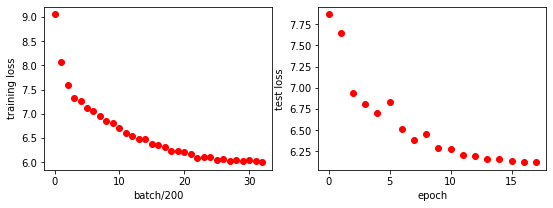

***Model 2*** 
 Parameters 1.1E+06


Batch 200 | lr = 5.490 | time =  0.11 | train_loss  9.25
Batch 400 | lr = 5.459 | time =  0.10 | train_loss  7.76
Batch 600 | lr = 5.408 | time =  0.11 | train_loss  7.42
Batch 800 | lr = 5.337 | time =  0.11 | train_loss  7.22
Batch 1000 | lr = 5.246 | time =  0.10 | train_loss  7.08
Batch 1200 | lr = 5.137 | time =  0.10 | train_loss  6.99
Batch 1400 | lr = 5.010 | time =  0.10 | train_loss  6.92
Batch 1600 | lr = 4.867 | time =  0.10 | train_loss  6.84
Batch 1800 | lr = 4.708 | time =  0.10 | train_loss  6.75
Batch 2000 | lr = 4.535 | time =  0.12 | train_loss  6.64
Batch 2200 | lr = 4.349 | time =  0.11 | train_loss  6.59
Epoch: 0 | time: 71.77 | test_loss =  6.41

Batch 200 | lr = 4.007 | time =  0.10 | train_loss  6.47
Batch 400 | lr = 3.795 | time =  0.11 | train_loss  6.44
Batch 600 | lr = 3.576 | time =  0.12 | train_loss  6.36
Batch 800 | lr = 3.352 | time =  0.12 | train_loss  6.33
Batch 1000 | lr = 3.126 | time =  0.17 | train_loss  6.31

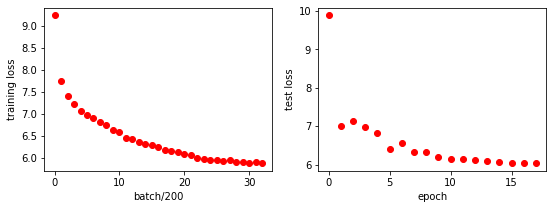

***Model 3*** 
 Parameters 1.9E+06


Batch 200 | lr = 5.490 | time =  0.12 | train_loss  9.77
Batch 400 | lr = 5.459 | time =  0.15 | train_loss  7.94
Batch 600 | lr = 5.408 | time =  0.14 | train_loss  7.52
Batch 800 | lr = 5.337 | time =  0.13 | train_loss  7.27
Batch 1000 | lr = 5.246 | time =  0.13 | train_loss  7.04
Batch 1200 | lr = 5.137 | time =  0.14 | train_loss  7.02
Batch 1400 | lr = 5.010 | time =  0.13 | train_loss  6.88
Batch 1600 | lr = 4.867 | time =  0.14 | train_loss  6.84
Batch 1800 | lr = 4.708 | time =  0.15 | train_loss  6.71
Batch 2000 | lr = 4.535 | time =  0.13 | train_loss  6.67
Batch 2200 | lr = 4.349 | time =  0.14 | train_loss  6.62
Epoch: 0 | time: 87.53 | test_loss =  6.44

Batch 200 | lr = 4.007 | time =  0.13 | train_loss  6.47
Batch 400 | lr = 3.795 | time =  0.13 | train_loss  6.44
Batch 600 | lr = 3.576 | time =  0.13 | train_loss  6.38
Batch 800 | lr = 3.352 | time =  0.14 | train_loss  6.34
Batch 1000 | lr = 3.126 | time =  0.13 | train_loss  6.27

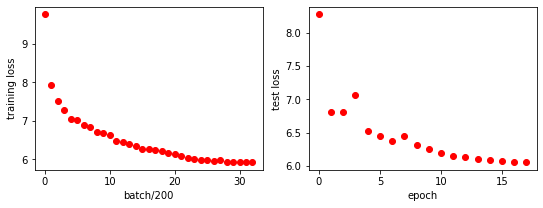

***Model 4*** 
 Parameters 7.2E+05


Batch 200 | lr = 5.490 | time =  0.09 | train_loss  9.15
Batch 400 | lr = 5.459 | time =  0.11 | train_loss  8.43
Batch 600 | lr = 5.408 | time =  0.08 | train_loss  8.07
Batch 800 | lr = 5.337 | time =  0.12 | train_loss  7.95
Batch 1000 | lr = 5.246 | time =  0.09 | train_loss  7.85
Batch 1200 | lr = 5.137 | time =  0.11 | train_loss  7.79
Batch 1400 | lr = 5.010 | time =  0.09 | train_loss  7.70
Batch 1600 | lr = 4.867 | time =  0.09 | train_loss  7.69
Batch 1800 | lr = 4.708 | time =  0.09 | train_loss  7.62
Batch 2000 | lr = 4.535 | time =  0.08 | train_loss  7.54
Batch 2200 | lr = 4.349 | time =  0.09 | train_loss  7.52
Epoch: 0 | time: 69.27 | test_loss =  7.68

Batch 200 | lr = 4.007 | time =  0.09 | train_loss  7.35
Batch 400 | lr = 3.795 | time =  0.09 | train_loss  7.22
Batch 600 | lr = 3.576 | time =  0.09 | train_loss  7.12
Batch 800 | lr = 3.352 | time =  0.09 | train_loss  6.95
Batch 1000 | lr = 3.126 | time =  0.10 | train_loss  6.83

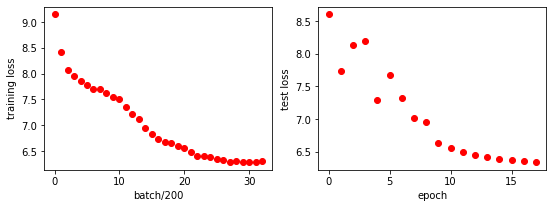

***Model 5*** 
 Parameters 9.6E+05


Batch 200 | lr = 5.490 | time =  0.11 | train_loss  9.15
Batch 400 | lr = 5.459 | time =  0.11 | train_loss  8.30
Batch 600 | lr = 5.408 | time =  0.10 | train_loss  8.00
Batch 800 | lr = 5.337 | time =  0.10 | train_loss  7.93
Batch 1000 | lr = 5.246 | time =  0.11 | train_loss  7.82
Batch 1200 | lr = 5.137 | time =  0.14 | train_loss  7.74
Batch 1400 | lr = 5.010 | time =  0.10 | train_loss  7.69
Batch 1600 | lr = 4.867 | time =  0.10 | train_loss  7.65
Batch 1800 | lr = 4.708 | time =  0.15 | train_loss  7.59
Batch 2000 | lr = 4.535 | time =  0.10 | train_loss  7.56
Batch 2200 | lr = 4.349 | time =  0.14 | train_loss  7.49
Epoch: 0 | time: 84.46 | test_loss =  7.73

Batch 200 | lr = 4.007 | time =  0.14 | train_loss  7.38
Batch 400 | lr = 3.795 | time =  0.10 | train_loss  7.31
Batch 600 | lr = 3.576 | time =  0.10 | train_loss  7.29
Batch 800 | lr = 3.352 | time =  0.12 | train_loss  7.24
Batch 1000 | lr = 3.126 | time =  0.10 | train_loss  7.18

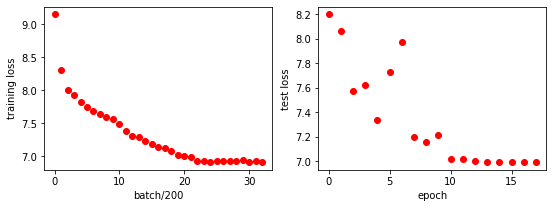

***Model 6*** 
 Parameters 1.6E+06


Batch 200 | lr = 5.490 | time =  0.12 | train_loss  9.52
Batch 400 | lr = 5.459 | time =  0.12 | train_loss  8.44
Batch 600 | lr = 5.408 | time =  0.12 | train_loss  8.07
Batch 800 | lr = 5.337 | time =  0.12 | train_loss  7.96
Batch 1000 | lr = 5.246 | time =  0.12 | train_loss  7.84
Batch 1200 | lr = 5.137 | time =  0.14 | train_loss  7.79
Batch 1400 | lr = 5.010 | time =  0.12 | train_loss  7.75
Batch 1600 | lr = 4.867 | time =  0.12 | train_loss  7.66
Batch 1800 | lr = 4.708 | time =  0.13 | train_loss  7.60
Batch 2000 | lr = 4.535 | time =  0.11 | train_loss  7.53
Batch 2200 | lr = 4.349 | time =  0.12 | train_loss  7.42
Epoch: 0 | time: 84.36 | test_loss =  6.99

Batch 200 | lr = 4.007 | time =  0.13 | train_loss  7.33
Batch 400 | lr = 3.795 | time =  0.11 | train_loss  7.26
Batch 600 | lr = 3.576 | time =  0.12 | train_loss  7.19
Batch 800 | lr = 3.352 | time =  0.12 | train_loss  7.07
Batch 1000 | lr = 3.126 | time =  0.12 | train_loss  6.96

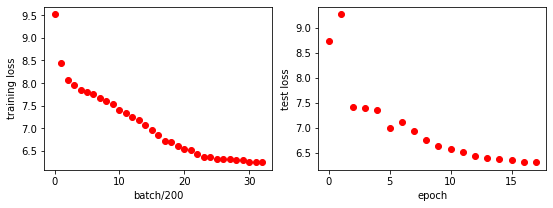

***Model 7*** 
 Parameters 3.8E+06


Batch 200 | lr = 5.490 | time =  0.16 | train_loss 10.06
Batch 400 | lr = 5.459 | time =  0.17 | train_loss  8.39
Batch 600 | lr = 5.408 | time =  0.16 | train_loss  8.14
Batch 800 | lr = 5.337 | time =  0.17 | train_loss  8.00
Batch 1000 | lr = 5.246 | time =  0.15 | train_loss  7.84
Batch 1200 | lr = 5.137 | time =  0.16 | train_loss  7.82
Batch 1400 | lr = 5.010 | time =  0.13 | train_loss  7.74
Batch 1600 | lr = 4.867 | time =  0.16 | train_loss  7.63
Batch 1800 | lr = 4.708 | time =  0.16 | train_loss  7.60
Batch 2000 | lr = 4.535 | time =  0.16 | train_loss  7.55
Batch 2200 | lr = 4.349 | time =  0.17 | train_loss  7.50
Epoch: 0 | time: 112.15 | test_loss =  7.53

Batch 200 | lr = 4.007 | time =  0.18 | train_loss  7.39
Batch 400 | lr = 3.795 | time =  0.16 | train_loss  7.32
Batch 600 | lr = 3.576 | time =  0.14 | train_loss  7.25
Batch 800 | lr = 3.352 | time =  0.19 | train_loss  7.24
Batch 1000 | lr = 3.126 | time =  0.17 | train_loss  7.2

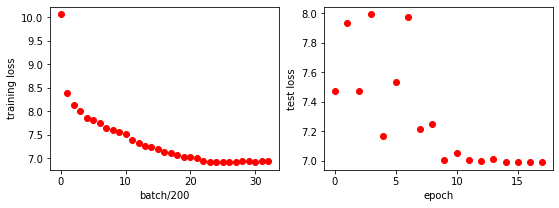

In [12]:
criterion = nn.CrossEntropyLoss()
model_train_curves = []
model_test_curves =[]
min_losses = []
k=0
for state in [*states_wide, *states_deep[1:], *states_scaled[1:]]:
    #build model
    print(f"***Model {k+1}*** \n Parameters {param_count[k]:.1E}\n\n")
    k+=1
    parts = mb.get_transformer_parts(state)
    model = lay.EncoderModel(parts.encoder, parts.linear).to(state.device)
    #train model
    opt, scheduler = mb.get_optimizer(state, model)
    trainer = mt.Model_training(model, opt, criterion, scheduler)
    trainer(epochs=3, data= dataset)
    #record training data
    min_losses.append(trainer.min_loss)
    model_train_curves.append(trainer.train_loss)
    model_test_curves.append(trainer.test_loss)



# Results

We observe a nice convergence for all models and a monotonic increase of performance as a function of network width at fixed depth = 2 layers.

The performance increase, however, is small so it leads me to believe we are in the data saturated regime (we already close the optimal model size for the amount of data and the latter is now bottlenecking performance) 

I also observe an increase in the initial loss as the function of the size, leading me to believe there exists a better initialization of the network

Text(0.5, 1.0, 'Fixed depth = 2 layers')

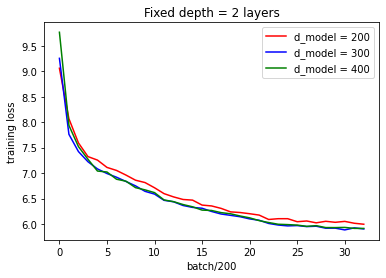

In [13]:
plt.plot(model_train_curves[0], "r", label="d_model = 200")
plt.plot(model_train_curves[1], "b", label="d_model = 300")
plt.plot(model_train_curves[2], "g", label="d_model = 400") 
plt.legend(loc = "upper right")
plt.ylabel("training loss")
plt.xlabel("batch/200")
plt.title("Fixed depth = 2 layers")


Text(0.5, 1.0, 'Fixed depth = 2 layers')

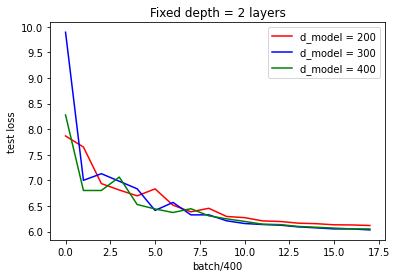

In [14]:
plt.plot(model_test_curves[0], "r",  label="d_model = 200") 
plt.plot(model_test_curves[1], "b",  label="d_model = 300")
plt.plot(model_test_curves[2], "g", label="d_model = 400")
plt.legend(loc = "upper right")
plt.ylabel("test loss")
plt.xlabel("batch/400")
plt.title("Fixed depth = 2 layers")


On the other hand, we observe a rather dramatic decrease of performance as a function of depth at fixed width. I tentatively attribute this to bad information propagation through the network at fixed width as we increase the depth. (I did the same experiment using Pytorch's built in Transformer model to rule out code bugs and it exhibited a similar behavior)

Text(0.5, 1.0, 'Fixed width = 200')

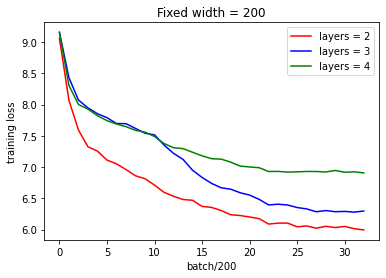

In [15]:
plt.plot(model_train_curves[0], "r", label="layers = 2")
plt.plot(model_train_curves[3], "b", label="layers = 3")
plt.plot(model_train_curves[4], "g", label="layers = 4") 
plt.legend(loc = "upper right")
plt.ylabel("training loss")
plt.xlabel("batch/200")
plt.title("Fixed width = 200")

Text(0.5, 1.0, 'Fixed width = 200')

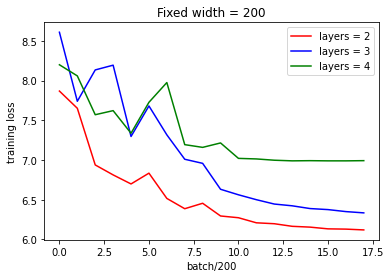

In [16]:
plt.plot(model_test_curves[0], "r", label="layers = 2")
plt.plot(model_test_curves[3], "b", label="layers = 3")
plt.plot(model_test_curves[4], "g", label="layers = 4") 
plt.legend(loc = "upper right")
plt.ylabel("training loss")
plt.xlabel("batch/200")
plt.title("Fixed width = 200")

Plot of minimal loss as a function of model size.

---
We indeed see that keeping the aspect ratio of the network fixed as we increase the depth substantially improves the performance of the deeper network. However it is still suboptimal to the fixed depth networks, suggesting that the optimal aspect ratio is much smaller than the one I used.


Text(0.5, 0, 'size')

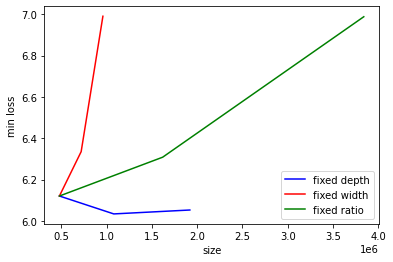

In [17]:
plt.plot(param_count[:3], min_losses[:3], "b", label="fixed depth")
plt.plot([param_count[0]]+ param_count[3:5], [min_losses[0]] +min_losses[3:5], "r", label= "fixed width")
plt.plot([param_count[0]]+ param_count[5:], [min_losses[0]] +min_losses[5:], "g", label= "fixed ratio")
plt.legend(loc = "lower right")

plt.ylabel("min loss")
plt.xlabel("size")

# Experiment 2: Smaller models
-- Here we observe a very clear power law in the network performance! I think this is good evidence for the validity of my previous hypothesis that the larger models were bottlenecked by the training data and we were already too close to the optimal size.

In [ ]:
small_states_wide = [lay.Network_state() for _ in range(5)]
for k, state in enumerate(small_states_wide):
    p= state.parameters
    tr= state.training

    p.d_model=40*(k+1)
    p.d_hid=40*(k+1)
    p.nheads=2
    p.d_key = p.d_model //p.nheads
    p.nlayers=2
    p.network = "encoder"


    tr.batch_size=20
    tr.data_split = 0.8 #fraction of dataset that will be used for training vs validation
    tr.lr = 1.
    tr.seq_length=35
    tr.optimizer = "sgd"

In [ ]:
dataset = dt.Data()
num_epochs = 3

dataset.tokenizer, dataset.train_dataloader, dataset.test_dataloader = dt.process_data(train_iter, txt.library_text_coders, small_states_wide[0], network= "encoder")
for s in small_states_wide:
  s.parameters.ntokens = s.parameters.ntokens_out = len(dataset.tokenizer.vocab)
  s.training.schedule = learning_rate_cosine(factor=5., length = 2300*num_epochs, finalLR=0.5)

***Model 1*** 
 Parameters 1.9E+04


Batch 200 | lr = 5.490 | time =  0.05 | train_loss  8.82
Batch 400 | lr = 5.459 | time =  0.06 | train_loss  8.10
Batch 600 | lr = 5.408 | time =  0.08 | train_loss  7.92
Batch 800 | lr = 5.337 | time =  0.06 | train_loss  7.84
Batch 1000 | lr = 5.246 | time =  0.06 | train_loss  7.82
Batch 1200 | lr = 5.137 | time =  0.06 | train_loss  7.73
Batch 1400 | lr = 5.010 | time =  0.06 | train_loss  7.62
Batch 1600 | lr = 4.867 | time =  0.06 | train_loss  7.57
Batch 1800 | lr = 4.708 | time =  0.06 | train_loss  7.35
Batch 2000 | lr = 4.535 | time =  0.09 | train_loss  7.29
Batch 2200 | lr = 4.349 | time =  0.06 | train_loss  7.22
Epoch: 0 | time: 44.97 | test_loss =  7.07

Batch 200 | lr = 4.007 | time =  0.08 | train_loss  7.03
Batch 400 | lr = 3.795 | time =  0.06 | train_loss  6.98
Batch 600 | lr = 3.576 | time =  0.06 | train_loss  6.94
Batch 800 | lr = 3.352 | time =  0.06 | train_loss  6.88
Batch 1000 | lr = 3.126 | time =  0.10 | train_loss  6.79

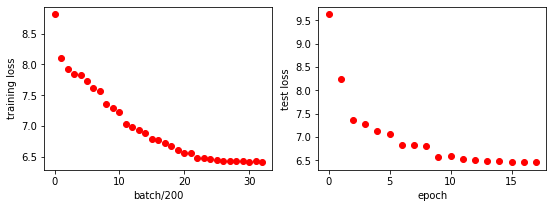

***Model 2*** 
 Parameters 7.7E+04


Batch 200 | lr = 5.490 | time =  0.06 | train_loss  8.72
Batch 400 | lr = 5.459 | time =  0.06 | train_loss  7.88
Batch 600 | lr = 5.408 | time =  0.09 | train_loss  7.58
Batch 800 | lr = 5.337 | time =  0.06 | train_loss  7.40
Batch 1000 | lr = 5.246 | time =  0.06 | train_loss  7.28
Batch 1200 | lr = 5.137 | time =  0.07 | train_loss  7.23
Batch 1400 | lr = 5.010 | time =  0.06 | train_loss  7.10
Batch 1600 | lr = 4.867 | time =  0.06 | train_loss  7.04
Batch 1800 | lr = 4.708 | time =  0.06 | train_loss  6.98
Batch 2000 | lr = 4.535 | time =  0.08 | train_loss  6.93
Batch 2200 | lr = 4.349 | time =  0.06 | train_loss  6.84
Epoch: 0 | time: 48.01 | test_loss =  6.88

Batch 200 | lr = 4.007 | time =  0.09 | train_loss  6.71
Batch 400 | lr = 3.795 | time =  0.06 | train_loss  6.69
Batch 600 | lr = 3.576 | time =  0.06 | train_loss  6.62
Batch 800 | lr = 3.352 | time =  0.09 | train_loss  6.58
Batch 1000 | lr = 3.126 | time =  0.06 | train_loss  6.55

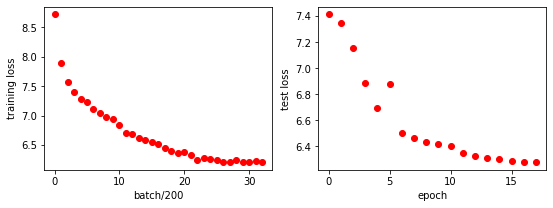

***Model 3*** 
 Parameters 1.7E+05


Batch 200 | lr = 5.490 | time =  0.06 | train_loss  8.86
Batch 400 | lr = 5.459 | time =  0.08 | train_loss  8.06
Batch 600 | lr = 5.408 | time =  0.06 | train_loss  7.61
Batch 800 | lr = 5.337 | time =  0.06 | train_loss  7.41
Batch 1000 | lr = 5.246 | time =  0.08 | train_loss  7.31
Batch 1200 | lr = 5.137 | time =  0.06 | train_loss  7.19
Batch 1400 | lr = 5.010 | time =  0.06 | train_loss  7.04
Batch 1600 | lr = 4.867 | time =  0.08 | train_loss  7.00
Batch 1800 | lr = 4.708 | time =  0.06 | train_loss  6.91
Batch 2000 | lr = 4.535 | time =  0.06 | train_loss  6.87
Batch 2200 | lr = 4.349 | time =  0.08 | train_loss  6.82
Epoch: 0 | time: 51.05 | test_loss =  6.88

Batch 200 | lr = 4.007 | time =  0.06 | train_loss  6.69
Batch 400 | lr = 3.795 | time =  0.12 | train_loss  6.63
Batch 600 | lr = 3.576 | time =  0.06 | train_loss  6.61
Batch 800 | lr = 3.352 | time =  0.06 | train_loss  6.54
Batch 1000 | lr = 3.126 | time =  0.08 | train_loss  6.51

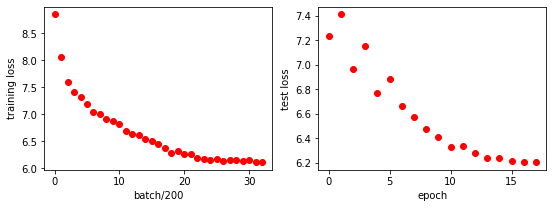

***Model 4*** 
 Parameters 3.1E+05


Batch 200 | lr = 5.490 | time =  0.08 | train_loss  9.02
Batch 400 | lr = 5.459 | time =  0.09 | train_loss  8.07
Batch 600 | lr = 5.408 | time =  0.08 | train_loss  7.60
Batch 800 | lr = 5.337 | time =  0.08 | train_loss  7.44
Batch 1000 | lr = 5.246 | time =  0.07 | train_loss  7.31
Batch 1200 | lr = 5.137 | time =  0.07 | train_loss  7.15
Batch 1400 | lr = 5.010 | time =  0.09 | train_loss  7.13
Batch 1600 | lr = 4.867 | time =  0.07 | train_loss  6.98
Batch 1800 | lr = 4.708 | time =  0.07 | train_loss  6.92
Batch 2000 | lr = 4.535 | time =  0.08 | train_loss  6.85
Batch 2200 | lr = 4.349 | time =  0.07 | train_loss  6.81
Epoch: 0 | time: 56.19 | test_loss =  6.59

Batch 200 | lr = 4.007 | time =  0.07 | train_loss  6.65
Batch 400 | lr = 3.795 | time =  0.07 | train_loss  6.55
Batch 600 | lr = 3.576 | time =  0.11 | train_loss  6.52
Batch 800 | lr = 3.352 | time =  0.07 | train_loss  6.46
Batch 1000 | lr = 3.126 | time =  0.08 | train_loss  6.41

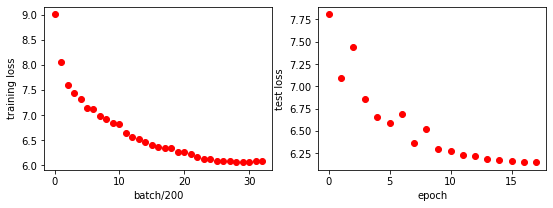

***Model 5*** 
 Parameters 4.8E+05


Batch 200 | lr = 5.490 | time =  0.09 | train_loss  9.10
Batch 400 | lr = 5.459 | time =  0.07 | train_loss  7.98
Batch 600 | lr = 5.408 | time =  0.08 | train_loss  7.55
Batch 800 | lr = 5.337 | time =  0.09 | train_loss  7.40
Batch 1000 | lr = 5.246 | time =  0.08 | train_loss  7.27
Batch 1200 | lr = 5.137 | time =  0.09 | train_loss  7.14
Batch 1400 | lr = 5.010 | time =  0.08 | train_loss  7.03
Batch 1600 | lr = 4.867 | time =  0.08 | train_loss  6.97
Batch 1800 | lr = 4.708 | time =  0.08 | train_loss  6.82
Batch 2000 | lr = 4.535 | time =  0.08 | train_loss  6.82
Batch 2200 | lr = 4.349 | time =  0.09 | train_loss  6.74
Epoch: 0 | time: 59.55 | test_loss =  6.62

Batch 200 | lr = 4.007 | time =  0.07 | train_loss  6.61
Batch 400 | lr = 3.795 | time =  0.08 | train_loss  6.55
Batch 600 | lr = 3.576 | time =  0.08 | train_loss  6.52
Batch 800 | lr = 3.352 | time =  0.08 | train_loss  6.42
Batch 1000 | lr = 3.126 | time =  0.08 | train_loss  6.38

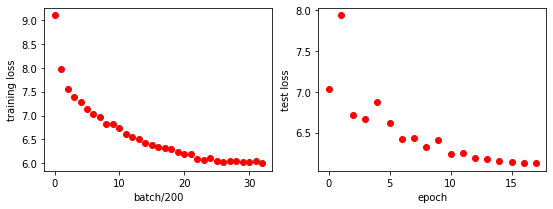

In [ ]:
criterion = nn.CrossEntropyLoss()
small_model_train_curves = []
small_model_test_curves =[]
small_min_losses = []
small_param_count = list(map(lay.param_count, small_states_wide))
k=0
for state in small_states_wide:
    #build model
    print(f"***Model {k+1}*** \n Parameters {small_param_count[k]:.1E}\n\n")
    k+=1
    parts = mb.get_transformer_parts(state)
    model = lay.EncoderModel(parts.encoder, parts.linear).to(state.device)
    #train model
    opt, scheduler = mb.get_optimizer(state, model)
    trainer = mt.Model_training(model, opt, criterion, scheduler)
    trainer(epochs=3, data= dataset)
    #record training data
    small_min_losses.append(trainer.min_loss)
    small_model_train_curves.append(trainer.train_loss)
    small_model_test_curves.append(trainer.test_loss)

Text(0.5, 1.0, 'Fixed depth = 2 layers')

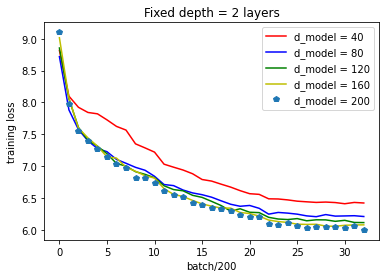

In [ ]:
plt.plot(small_model_train_curves[0], "r", label="d_model = 40")
plt.plot(small_model_train_curves[1], "b", label="d_model = 80")
plt.plot(small_model_train_curves[2], "g", label="d_model = 120") 
plt.plot(small_model_train_curves[3], "y", label="d_model = 160") 
plt.plot(small_model_train_curves[4], "p", label="d_model = 200") 
plt.legend(loc = "upper right")
plt.ylabel("training loss")
plt.xlabel("batch/200")
plt.title("Fixed depth = 2 layers")

Text(0.5, 1.0, 'Fixed depth = 2 layers')

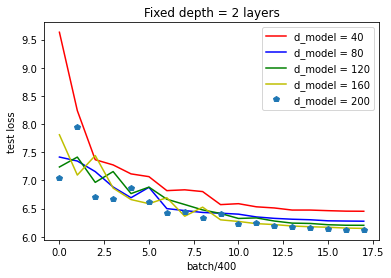

In [ ]:
plt.plot(small_model_test_curves[0], "r", label="d_model = 40")
plt.plot(small_model_test_curves[1], "b", label="d_model = 80")
plt.plot(small_model_test_curves[2], "g", label="d_model = 120") 
plt.plot(small_model_test_curves[3], "y", label="d_model = 160") 
plt.plot(small_model_test_curves[4], "p", label="d_model = 200") 
plt.legend(loc = "upper right")
plt.ylabel("test loss")
plt.xlabel("batch/400")
plt.title("Fixed depth = 2 layers")

Text(0.5, 0, 'size')

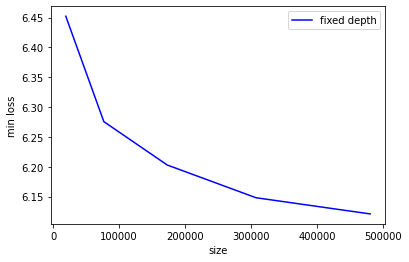

In [ ]:
plt.plot(small_param_count, small_min_losses, "b", label="fixed depth")
plt.legend(loc = "upper right")

plt.ylabel("min loss")
plt.xlabel("size")